In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video
import imageio

In [2]:
!pip install -U imageio imageio-ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.0
    Uninstalling imageio-2.25.0:
      Successfully uninstalled imageio-2.25.0


In [3]:
# Define Constant Variables
DATA_DIR = "/kaggle/input/asl-signs/"

# For Google Colab
# DATA_DIR = ""
SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
TRAIN = os.path.join(DATA_DIR,"train.csv")
TEST = os.path.join(DATA_DIR,"test.csv")

# Peak at train.csv

In [4]:
train = pd.read_csv(TRAIN)
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [5]:
## Pick up one train parquet
train_sample_path = 'train_landmark_files/25571/1000210073.parquet'
sample = pd.read_parquet(os.path.join(DATA_DIR,train_sample_path))
sample.head()

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314


In [6]:
print(f"All different types of landmark = {sample.type.unique()}")

All different types of landmark = ['face' 'left_hand' 'pose' 'right_hand']


In [7]:
sample_left_hand = sample[sample.type == "left_hand"]
sample_right_hand = sample[sample.type == "right_hand"]

print(f"Percentage of nulls in Left Hand data = {100*np.mean(sample_left_hand['x'].isnull()):.02f} %")
print(f"Percentage of nulls in Right Hand data = {100*np.mean(sample_right_hand['x'].isnull()):.02f} %")

Percentage of nulls in Left Hand data = 100.00 %
Percentage of nulls in Right Hand data = 0.00 %


In [8]:
sample_right_hand.head()

,frame,row_id,type,landmark_index,x,y,z
522,17,17-right_hand-0,right_hand,0,0.238483,0.711880,2.568674e-07
523,17,17-right_hand-1,right_hand,1,0.333519,0.688351,2.911205e-03
524,17,17-right_hand-2,right_hand,2,0.401921,0.657240,-1.464270e-02
525,17,17-right_hand-3,right_hand,3,0.459562,0.642153,-4.063156e-02
526,17,17-right_hand-4,right_hand,4,0.515201,0.637626,-6.589380e-02


Generate the animated frame according to [DANIELPESHKOV](https://www.kaggle.com/code/danielpeshkov/animated-data-visualization/notebook)'s Notebook.

In [9]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def animation_frame(frame, hand_df):    
    hand_df_in_frame = hand_df[hand_df.frame==frame]
    lx, ly = get_hand_points(hand_df_in_frame)
    ax.clear()
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

Frame size: 12


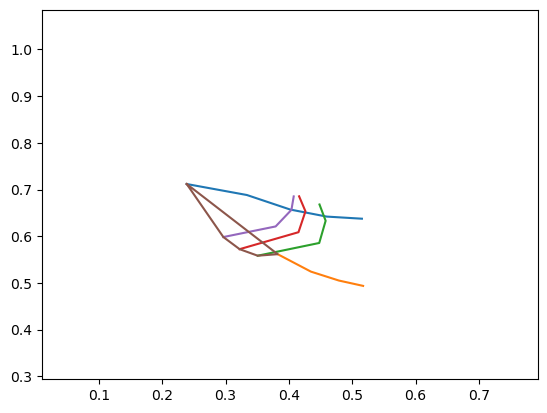

In [10]:
hand_df = sample_right_hand.dropna()

## Print the # of frames
print(f'Frame size: {len(hand_df.frame.unique())}')

## These values set the limits on the graph to stabilize the video
xmin = hand_df.x.min() - 0.2
xmax = hand_df.x.max() + 0.2
ymin = hand_df.y.min() - 0.2
ymax = hand_df.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])

animation = FuncAnimation(fig, 
                          func=animation_frame, 
                          frames=hand_df.frame.unique(), 
                          fargs=(hand_df,) # Arguments set into the function
                         )
HTML(animation.to_html5_video())

In [11]:
## Pick up another train parquet
train_sample2_path = 'train_landmark_files/62590/1000240708.parquet'
sample2 = pd.read_parquet(os.path.join(DATA_DIR,train_sample2_path))
sample2.head()

,frame,row_id,type,landmark_index,x,y,z
0,22,22-face-0,face,0,0.474619,0.532578,-0.040578
1,22,22-face-1,face,1,0.463594,0.502445,-0.054907
2,22,22-face-2,face,2,0.468326,0.514738,-0.033773
3,22,22-face-3,face,3,0.455096,0.481366,-0.031003
4,22,22-face-4,face,4,0.462416,0.494422,-0.055953


In [12]:
sample2_left_hand = sample2[sample2.type == "left_hand"]
sample2_right_hand = sample2[sample2.type == "right_hand"]

print(f"Percentage of nulls in Left Hand data = {100*np.mean(sample2_left_hand['x'].isnull()):.02f} %")
print(f"Percentage of nulls in Right Hand data = {100*np.mean(sample2_right_hand['x'].isnull()):.02f} %")

Percentage of nulls in Left Hand data = 100.00 %
Percentage of nulls in Right Hand data = 0.00 %


Frame size: 18


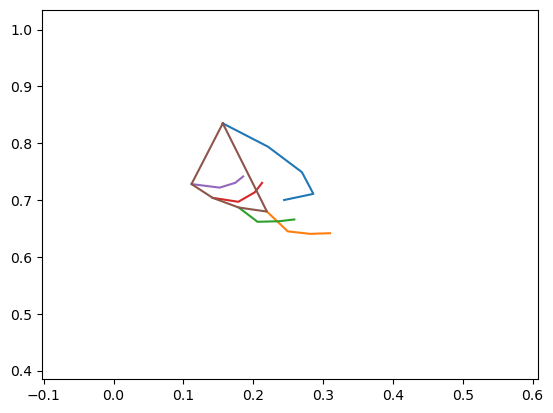

In [13]:
hand_df = sample2_right_hand.dropna()

## Print the # of frames
print(f'Frame size: {len(hand_df.frame.unique())}')

## These values set the limits on the graph to stabilize the video
xmin = hand_df.x.min() - 0.2
xmax = hand_df.x.max() + 0.2
ymin = hand_df.y.min() - 0.2
ymax = hand_df.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])

animation = FuncAnimation(fig, 
                          func=animation_frame, 
                          frames=hand_df.frame.unique(), 
                          fargs=(hand_df,) # Arguments set into the function
                         )
# HTML(animation.to_html5_video())

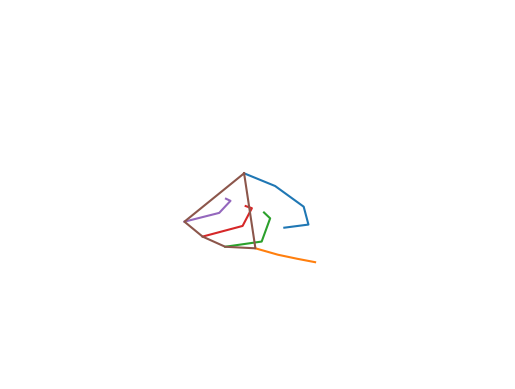

In [14]:
frame = 30

## These values set the limits on the graph to stabilize the video
xmin = hand_df.x.min() - 0.2
xmax = hand_df.x.max() + 0.2
ymin = hand_df.y.min() - 0.2
ymax = hand_df.y.max() + 0.2

hand_df_in_frame = hand_df[hand_df.frame==frame]

lx, ly = get_hand_points(hand_df_in_frame)

fig, ax = plt.subplots()

ax.clear()
for i in range(len(lx)):
    ax.plot(lx[i], ly[i])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# remove the axis
ax.set_axis_off()

plt.show()

# Draw the figure first before saving it to numpy
fig.canvas.draw()

# Now we can save it to a numpy array.
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

(480, 640, 3)


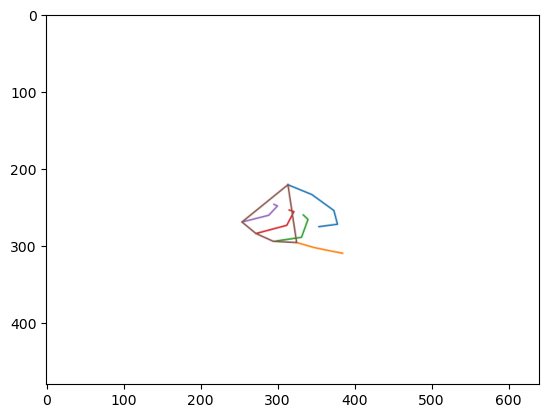

In [15]:
print(data.shape)

# plot the image using matplotlib
plt.imshow(data)
plt.show()